# Density vs. Difference

We want determine if the number of observations per pixel in the iNaturalis map relates to the difference between the sPlotOpen and iNaturalist map.

This section covers:

- Load Data
- Count observations per grid cell
- Observation density vs. Discrepancy between iNat and sPlotOpen

In [ ]:
# packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


## Load Data

Load iNaturalist-TRY data and sPlotOpen community weighted means

In [22]:
iNat_TRY = pd.read_csv("iNat_TRY_log.csv")
iNat_TRY.head(2)

,gbifID,scientificName,decimalLatitude,decimalLongitude,eventDate,dateIdentified,Dispersal unit length,Leaf Area,SLA,Leaf C,...,Leaf delta15N,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length
0,1229615436,Commelina communis,35.987483,-79.057546,2013-07-07T00:00:00,2013-07-07T20:33:11,NaN,NaN,NaN,NaN,...,NaN,2.5362,0.536493,NaN,2.13771,NaN,NaN,NaN,NaN,NaN
1,3384000233,Commelina communis,42.093762,-75.923660,2021-08-23T13:06:06,2021-09-17T21:15:37,NaN,NaN,NaN,NaN,...,NaN,2.5362,0.536493,NaN,2.13771,NaN,NaN,NaN,NaN,NaN


In [ ]:
sPlot = pd.read_csv("sPlotOpen/cwm_loc.csv")

In [4]:
sPlot.head(2)

,PlotObservationID,TraitCoverage_cover,Species_richness,TraitCoverage_pa,Leaf Area,SSD,SLA,Leaf C,Leaf N per mass,Leaf P,...,Height_shrubs_lowest,Height_herbs_average,Height_herbs_lowest,Height_herbs_highest,SoilClim_PC1,SoilClim_PC2,Resample_1,Resample_2,Resample_3,Resample_1_consensus
0,16,0.277778,3,0.333333,3.678311,-1.047293,2.890748,6.128157,2.873263,1.114036,...,NaN,NaN,NaN,NaN,-3.66,0.546,True,False,False,True
1,17,0.038462,2,0.500000,3.678311,-1.047293,2.890748,6.128157,2.873263,1.114036,...,NaN,NaN,NaN,NaN,-3.66,0.546,True,False,False,True


## Count observations per grid cell

In [24]:
def global_grid_count(df, long, lat, deg, variables):
    
    # create new dataframe to save the average value of each grid cell and variable
    grouped_df = pd.DataFrame()
    
    # convert degree into step size
    step = int((360/deg) + 1)
    
    bins_x = np.linspace(-180,180,step) 
    bins_y= np.linspace(-90,90,int(((step - 1)/2)+1))
    
    # group latitude and longitude coordinates into bins
    # create new columns 'x_bin' and 'y_bin'
    df['x_bin'] = pd.cut(df[long], bins=bins_x)
    df['y_bin'] = pd.cut(df[lat], bins=bins_y)
    
    # raster coordinates are in center of raster cell
    df['x_bin'] = df['x_bin'].apply(lambda x: ((x.left + x.right) /2) )
    df['y_bin'] = df['y_bin'].apply(lambda x: ((x.left + x.right) /2) )
    
    grouped_df = df.drop_duplicates(subset=['x_bin', 'y_bin'], keep='last')
    grouped_df = grouped_df[['x_bin', 'y_bin']]
    
    for v in variables:
        
        sub_df = df[['y_bin', 'x_bin', v]]
        
        # for each lat/lon group get count
        grouped_v = sub_df.groupby(['x_bin', 'y_bin'], as_index=False)[v].count()
        
        
        grouped_df = pd.merge(grouped_df, grouped_v, 
                    on= ['x_bin', 'y_bin'], 
                    how='left')
        
    return grouped_df

In [25]:
# get counts

deg = [2]


trait = iNat_TRY.columns[6:24]

for d in deg:
    df_iNat = global_grid_count(iNat_TRY, 'decimalLongitude', 'decimalLatitude', d, trait)
    
    df_sPlot = global_grid_count(sPlot, 'Longitude', 'Latitude', d, trait)
    
    
    # reshape data, so that we have only one Trait column
    df_iNat_t = df_iNat.melt(id_vars=["x_bin", "y_bin"], 
                     value_name="Count_iNat", 
                     var_name="Trait")
    
    df_sPlot_t = df_sPlot.melt(id_vars=["x_bin", "y_bin"], 
                     value_name="Count_sPlot", 
                     var_name="Trait")
    
    # merge sPlot and iNat data into one dataframe
    df_merged = pd.merge(df_sPlot_t, df_iNat_t, on=["x_bin", "y_bin", "Trait"] )
    
    # keep only lines where we have a pixel in both datasets
    df_merged = df_merged.dropna()
    
    
    # save result to csv
    filename="grid_count_" + str(d) + "_deg.csv"
    df_merged.to_csv(filename, index=False)
    

## Compare observation density per grid cell to scaled difference between sPlot and iNaturalist

Open file that saved the counts per grid cell:

In [26]:
filename="grid_count_2_deg.csv"
counts = pd.read_csv(filename)
counts.head()

,x_bin,y_bin,Trait,Count_sPlot,Count_iNat
0,-155.0,63.0,Dispersal unit length,109,0
1,-155.0,69.0,Dispersal unit length,66,0
2,-157.0,69.0,Dispersal unit length,7,2
3,-163.0,67.0,Dispersal unit length,1,40
4,-157.0,65.0,Dispersal unit length,1,13


Load grid cell means at 2 degree resolution:

In [27]:
filename="grid_means_2_deg.csv"
means = pd.read_csv(filename)
means.head()

,x_bin,y_bin,Trait,TraitValue_sPlot,TraitValue_iNat
0,-157.0,69.0,Dispersal unit length,0.872919,1.898598
1,-163.0,67.0,Dispersal unit length,1.282093,1.265103
2,-157.0,65.0,Dispersal unit length,1.267266,1.079049
3,-153.0,65.0,Dispersal unit length,1.326229,1.485913
4,-147.0,69.0,Dispersal unit length,0.747151,0.876784


Normalize grid cell averages:

In [28]:
def quantile_norm(df, s1, s2, variables):
    
    # empty data frame to save output:
    df_norm = pd.DataFrame()
    
    for v in variables:
        
        # make subset df
        sub_exp = df[df['Trait']==v]
        sub_exp[s1] = np.exp(sub_exp[s1].copy())
        sub_exp[s2] = np.exp(sub_exp[s2].copy())
        
        # determine min and max values
        min_quantile = sub_exp[s1].quantile(0.05)
        max_quantile = sub_exp[s1].quantile(0.95)
        if min_quantile > sub_exp[s2].quantile(0.05):
            min_quantile = sub_exp[s2].quantile(0.05)
        if max_quantile < sub_exp[s2].quantile(0.95):
            max_quantile = sub_exp[s2].quantile(0.95)
      
        sub_exp[s1] = sub_exp[s1].apply(lambda x: (x - min_quantile)/(max_quantile - min_quantile))
        sub_exp[s2] = sub_exp[s2].apply(lambda x: (x - min_quantile)/(max_quantile - min_quantile))
        
        df_norm = pd.concat([df_norm, sub_exp])


    return df_norm

    

In [29]:
# normalize original values (exp of ln-values):
pd.options.mode.chained_assignment = None
means = quantile_norm(means, "TraitValue_sPlot", "TraitValue_iNat", trait)

In [32]:
means.head()

,x_bin,y_bin,Trait,TraitValue_sPlot,TraitValue_iNat,Difference
0,-157.0,69.0,Dispersal unit length,0.133789,0.777220,0.643432
1,-163.0,67.0,Dispersal unit length,0.315624,0.306502,0.009122
2,-157.0,65.0,Dispersal unit length,0.307655,0.216120,0.091535
3,-153.0,65.0,Dispersal unit length,0.340059,0.438045,0.097986
4,-147.0,69.0,Dispersal unit length,0.091284,0.135182,0.043898


In [33]:
# calculate absolute difference

means['Difference'] = abs(means['TraitValue_iNat'] - means['TraitValue_sPlot'])


In [34]:
means = pd.merge(means, counts, on = ['x_bin', 'y_bin', 'Trait' ])

Remove outliers:

In [35]:
import scipy.stats as stats 
z_scores = stats.zscore(means['Difference'])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
means = means[filtered_entries]

Plot distribution of the difference between iNautralist and sPlotOpen in each respective cell:

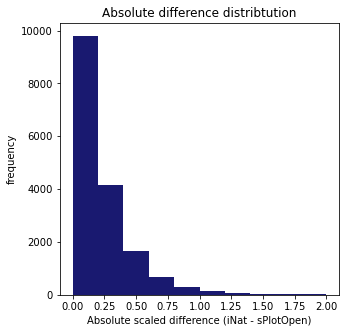

In [36]:
fig,ax = plt.subplots(figsize=(5,5))

plt.hist(means["Difference"], range=[0, 2], color="midnightblue")
plt.title("Absolute difference distribtution")
ax.set(xlabel = "Absolute scaled difference (iNat - sPlotOpen)", ylabel="frequency")


plt.savefig('../Figures/Absolute_difference_distribtution.pdf', bbox_inches='tight')

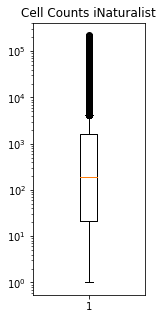

In [37]:
fig,ax = plt.subplots(figsize=(2,5))

plt.boxplot(means["Count_iNat"])
plt.title("Cell Counts iNaturalist")
ax.set_yscale('log')

plt.savefig('../Figures/Dist_cell_counts.pdf', bbox_inches='tight')

We bin all grid cells by the number of observations they hold. Each bin is defined by the 25% quantiles in the dataset. We can see that the cells in the first bin have only a maximum of 20 observations and exhibit a greater discrepancy from sPlotOpen.

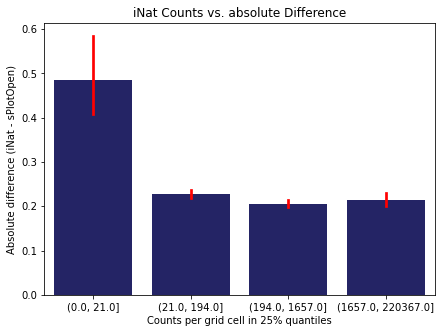

In [38]:
# define 25% quantile bins

means['Counts per grid cell'] = pd.cut(means['Count_iNat'], bins=[0
                                                        ,means['Count_iNat'].quantile(0.25)
                                                        ,means['Count_iNat'].quantile(0.50)
                                                        ,means['Count_iNat'].quantile(0.75)
                                                        ,means['Count_iNat'].quantile(1)])

fig,ax = plt.subplots(figsize=(7,5))

sns.barplot(x='Counts per grid cell', y='Difference', data=means, ax=ax, color="midnightblue", errcolor = "red")
ax.set(xlabel = "Counts per grid cell in 25% quantiles", ylabel="Absolute difference (iNat - sPlotOpen)")
ax.set(title= "iNat Counts vs. absolute Difference")

plt.savefig('../Figures/diff_vs_counts_all.pdf', bbox_inches='tight')

For each trait individually:

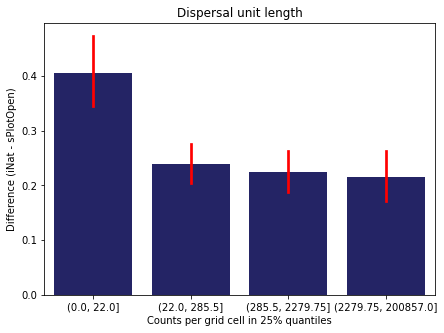

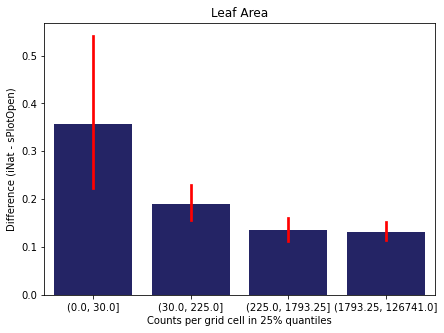

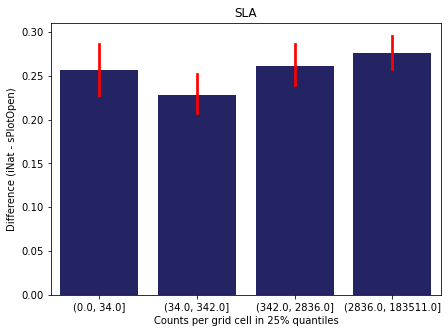

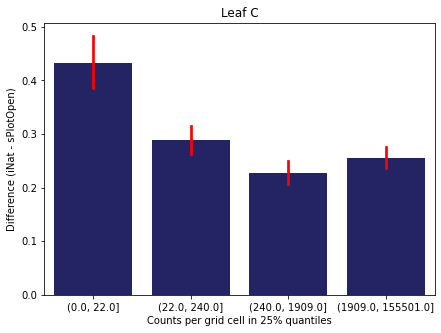

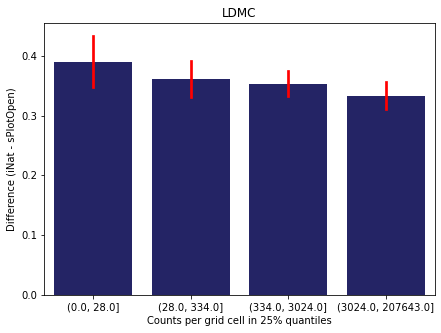

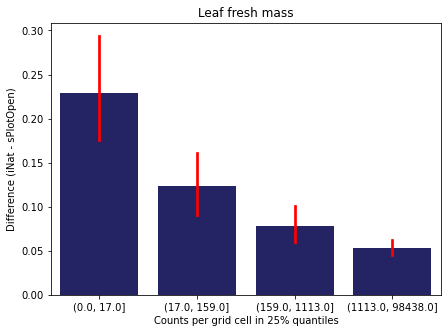

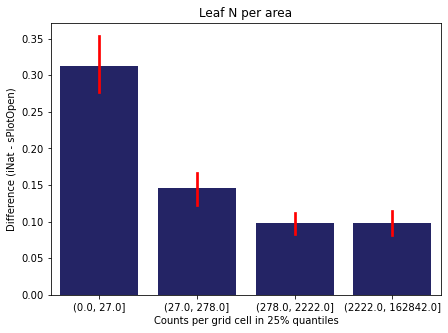

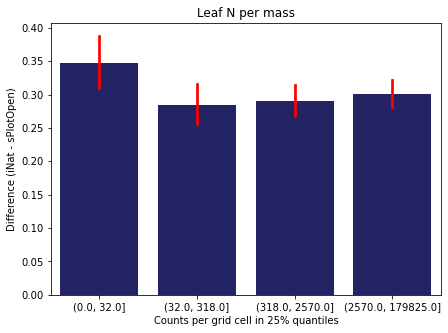

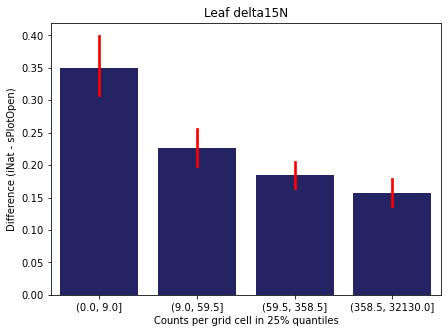

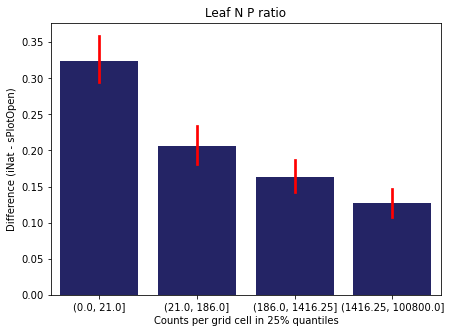

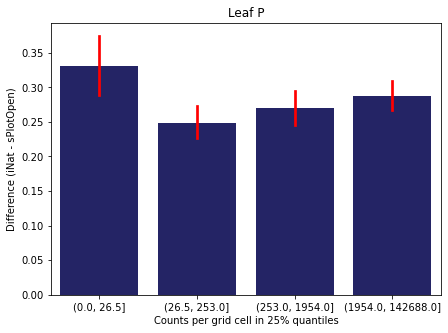

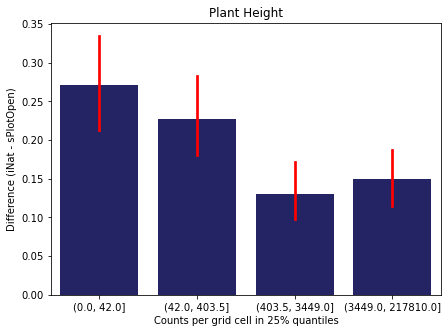

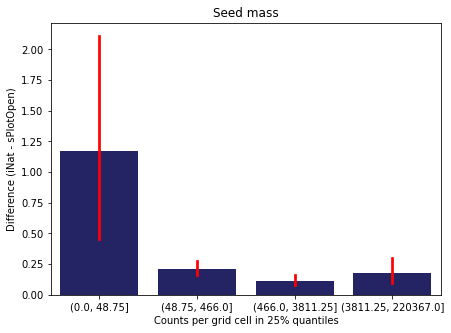

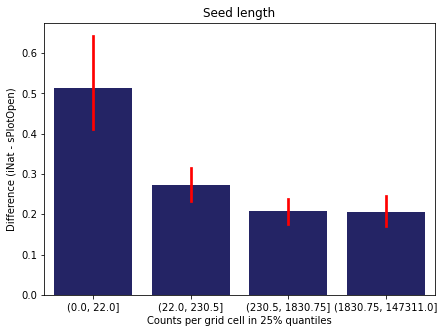

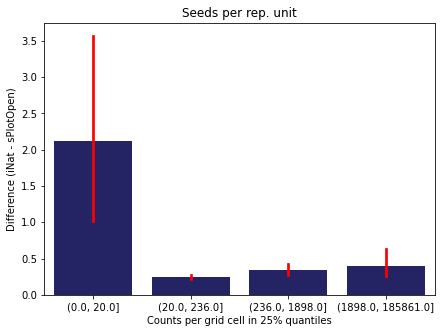

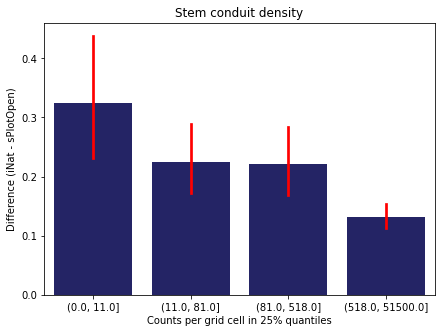

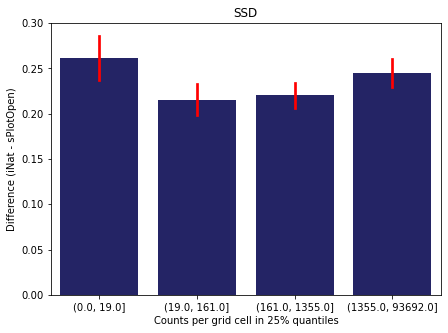

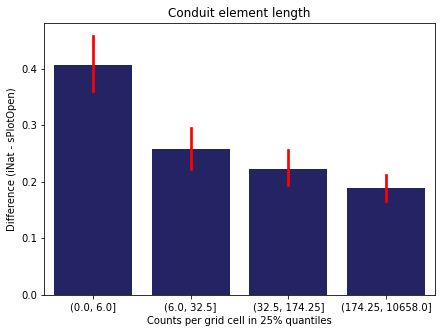

In [39]:
for t in trait:
    sub = means[means['Trait']==t]
    
    sub['Counts per grid cell'] = pd.cut(sub['Count_iNat'], bins=[0
                                                        ,sub['Count_iNat'].quantile(0.25)
                                                        ,sub['Count_iNat'].quantile(0.50)
                                                        ,sub['Count_iNat'].quantile(0.75)
                                                        ,sub['Count_iNat'].quantile(1)])


    fig,ax = plt.subplots(figsize=(7,5))
    
    sns.barplot(x='Counts per grid cell', y='Difference', data=sub, 
                ax=ax, color="midnightblue", errcolor = "red").set(title=t)
    ax.set(xlabel = "Counts per grid cell in 25% quantiles", ylabel="Difference (iNat - sPlotOpen)");

    

Same plot for sPlotOpen plot count

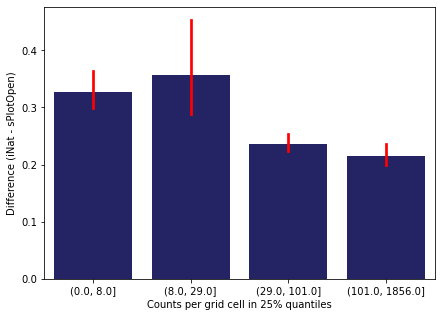

In [19]:
means['Counts per grid cell'] = pd.cut(means['Count_sPlot'], bins=[0
                                                        ,means['Count_sPlot'].quantile(0.25)
                                                        ,means['Count_sPlot'].quantile(0.50)
                                                        ,means['Count_sPlot'].quantile(0.75)
                                                        ,means['Count_sPlot'].quantile(1)])

fig,ax = plt.subplots(figsize=(7,5))

sns.barplot(x='Counts per grid cell', y='Difference', data=means, ax=ax, color="midnightblue", errcolor = "red")
ax.set(xlabel = "Counts per grid cell in 25% quantiles", ylabel="Difference (iNat - sPlotOpen)")

plt.savefig('../Figures/diff_vs_counts_sPlot.pdf', bbox_inches='tight')